In [163]:
import torch
import cv2
from unet import load_unet_dict, UNet
import torchvision
from AlexNet import AlexNet
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [164]:
DIP_unet = UNet(1, 1, final_activ='ClippedRelu').to(device)

In [13]:
AlbedoShadingNet = load_unet_dict("unet_dict_ORIG.pt").to(device)
DiscriminatorNet = load_unet_dict("disc_dict.pt").to(device)
# model_p = torchvision.models.alexnet(pretrained=True)
# RobustAlexNet = AlexNet(model_p)
# RobustAlexNet.load_state_dict(torch.load("model.pt"))

In [110]:
landscape_path = ".\\Landscapes\\00000002_(3).jpg"
object_path = ".\\chair.jpg"
object_mask_path = ".\\chair_mask.jpg"

In [111]:
#load ims
landscape_im = cv2.imread(landscape_path)
landscape_im = cv2.cvtColor(landscape_im, cv2.COLOR_BGR2RGB)
landscape_im = cv2.resize(landscape_im, (256, 256))
landscape_im = torch.tensor(landscape_im)/255
object_im = cv2.imread(object_path)
object_im = cv2.cvtColor(object_im, cv2.COLOR_BGR2RGB)
object_im = cv2.resize(object_im, (256, 256))
object_mask=cv2.imread(object_mask_path, 0)
object_mask=cv2.resize(object_mask, (256, 256))
object_im = torch.tensor(object_im)/255
object_mask= torch.tensor(object_mask)
object_mask = object_mask.float().unsqueeze(-1)/255
mask_g = torch.tensor(cv2.resize(object_mask.numpy(), (50, 50))).unsqueeze(-1)
object_g = torch.tensor(cv2.resize(object_im.numpy(), (50, 50)))
ow, oh, _ = object_g.shape

In [142]:
x_offset = 200
y_offset = 100
landscape_im_bg = landscape_im[x_offset:x_offset+ow, y_offset:y_offset+oh]
g = landscape_im_bg * (1 - mask_g) + mask_g * object_g
landscape_im_o = np.copy(landscape_im)
landscape_im_o[x_offset:x_offset+ow, y_offset:y_offset+oh] = landscape_im_bg * (1 - mask_g) + mask_g * object_g
M = np.zeros((256, 256, 1))
M[x_offset:x_offset+ow, y_offset:y_offset+oh, :] = mask_g
M = torch.tensor(M)

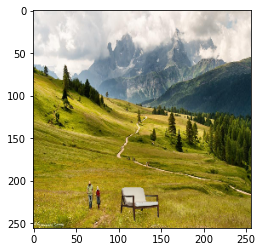

In [117]:
plt.imshow(landscape_im_o)

In [119]:
landscape_im_o = torch.tensor(landscape_im_o)

In [123]:
Albedo =  AlbedoShadingNet(landscape_im_o.permute(2, 0, 1).unsqueeze(0))[0, 0:3, :, :]
Shading = AlbedoShadingNet(landscape_im_o.permute(2, 0, 1).unsqueeze(0))[0, 3, :, :]

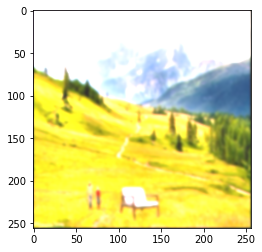

In [125]:
plt.imshow(Albedo.detach().permute(1, 2, 0).cpu().numpy())

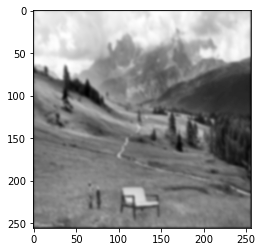

In [127]:
plt.imshow(Shading.detach().cpu().numpy(), cmap='gray')

In [133]:
inconsistency = DiscriminatorNet(Shading.unsqueeze(0).unsqueeze(0))[0, 0]

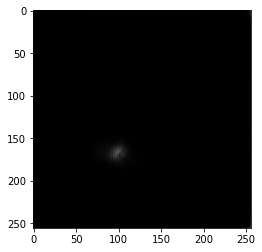

In [135]:
plt.imshow(inconsistency.detach().numpy(), cmap ='gray')

In [160]:
net_input_saved =  torch.randn((1, 1, 256, 256)).to(device)

In [ ]:
mse = torch.nn.MSELoss()
BATCH_SIZE = 16
def closure(net, img, mask, itr, pbar, reg_noise_std = 0.05, plot_interval = 500):
    
    # for n in [x for x in net.parameters() if len(x.size()) == 4]:
    #     n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    noise_shape = list(net_input.shape)
    noise_shape[0] = BATCH_SIZE
    noise = torch.randn(noise_shape).to(device) * reg_noise_std
    net_input = net_input_saved + noise
        
        
    out = net(net_input.to(device))
    errors = (out * mask) - (img * mask)
    inconsistencies = DiscriminatorNet(out)
    total_loss = (errors ** 2).sum()/ (BATCH_SIZE * img.shape[2] * img.shape[3]) + inconsistencies.sum()
    total_loss.backward()
        
    pbar.set_description ('Iteration %05d    Loss %f' % (itr, total_loss.item()))
    if itr % plot_interval == 0:
        out_np = out[0].detach().cpu().permute(1, 2, 0).numpy()
        plt.imshow(out_np)
        plt.show()

    return net_input, total_loss

LR = 1.0
num_iter = 5000
optimizer = torch.optim.Adadelta(DIP_unet.parameters(), lr=LR)
pbar = tqdm(range(num_iter), position=0, leave=True)
for itr in range(num_iter):
    optimizer.zero_grad()
    net_input, total_loss = closure(DIP_unet, Shading.to(device), (1 - M).to(device), itr, pbar)
    optimizer.step()
    pbar.update()
pbar.close()

In [ ]:
Shading = DIP_unet(net_input_saved)

In [168]:
out_im = Shading * Albedo

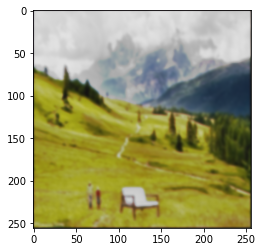

In [171]:
plt.imshow(out_im.detach().permute(1, 2, 0).numpy())